# TP3 — Classification d’images par Réseaux de Neurones Convolutifs (CNN)

**Auteur :** Adjaho SARA

##Objectifs pédagogiques

À la fin de ce TP, l’étudiant sera capable de :
* Charger et prétraiter un jeu d’images pour l’apprentissage automatique ;
* Concevoir et personnaliser un réseau de neurones convolutif (CNN) sous
TensorFlow/Keras ;
* Entraîner et évaluer son modèle ;
* Visualiser les performances du modèle (courbes, matrices de confusion, prédictions).


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping


Étape 1 : Chargement et exploration des données

In [ ]:
## Chargement du jeu de données MNIST
# Charger le jeu de données MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Afficher :


*   Le nombre d'images d'entraînement et de test,
*   Les dimensions des images,
*   Quelques exemples d'images avec leurs étiquettes.








In [ ]:
print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Le jeu de données est composé de 60 000 images d’entraînement et 10 000 images de test, chacune de taille 28×28 pixels en niveaux de gris. Les variables y_train et y_test contiennent les étiquettes correspondantes aux chiffres manuscrits (de 0 à 9) associés à chaque image

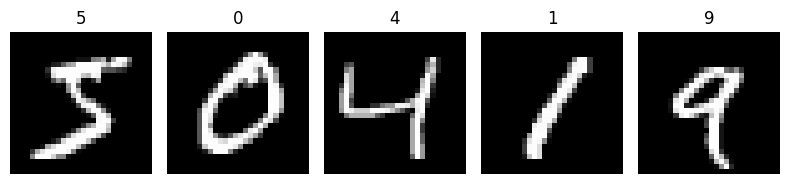

In [ ]:
plt.figure(figsize=(8, 2))  # largeur 8, hauteur 2

# Afficher 5 images côte à côte
for i in range(5):
    plt.subplot(1, 5, i + 1)  # 1 ligne, 5 colonnes
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

Étape 2 : Prétraitement des données

Avant l’entraînement du modèle, il a été nécessaire de préparer et normaliser les données afin de les rendre compatibles avec la structure du réseau de neurones convolutif (CNN). Les images du jeu de données ont d’abord été converties en valeurs de type float32 puis normalisées entre 0 et 1 en divisant chaque pixel par 255, ce qui permet de faciliter l’apprentissage en assurant une meilleure stabilité numérique. Ensuite, chaque image a été redimensionnée pour inclure une dimension supplémentaire correspondant au canal de couleur (ici égal à 1 puisque les images sont en niveaux de gris), afin de respecter le format attendu par les couches convolutives du modèle : (28, 28, 1). Enfin, les étiquettes des classes ont été encodées en vecteurs one-hot, une étape indispensable pour la classification multiclasses, permettant au modèle de traiter chaque chiffre comme une catégorie indépendante. Cette phase de prétraitement garantit ainsi une cohérence des données et une meilleure efficacité de l’apprentissage.

In [ ]:
#Reshape des images pour ajouter la dimension des canaux.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape des images pour ajouter la dimension des canaux.
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Encodage one-hot des étiquettes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Étape 3 : Conception du CNN

Le modèle conçu est un réseau de neurones convolutif (CNN) destiné à la classification d’images de dimension 28×28 pixels. Il est constitué de trois couches convolutionnelles successives, choisies pour permettre l’extraction progressive de caractéristiques hiérarchiques : la première couche comporte 32 filtres de taille 3×3, suffisants pour capturer les motifs simples tels que les bords et textures, tandis que les deux couches suivantes utilisent 64 filtres pour détecter des motifs plus complexes et abstraits. L’activation ReLU est utilisée dans chaque couche convolutionnelle afin de modéliser des relations non linéaires tout en évitant le problème de gradient nul. Chaque couche convolutionnelle est suivie d’un max pooling 2×2, ce qui permet de réduire les dimensions spatiales des cartes de caractéristiques, diminuer le nombre de paramètres et limiter le surapprentissage. Les cartes de caractéristiques sont ensuite aplaties (Flatten) pour être transmises à une couche dense de 128 neurones, choisie pour combiner efficacement les informations extraites par les convolutions. Une couche de dropout de 50 % est ajoutée pour régulariser le modèle et réduire le risque de surapprentissage. Enfin, la couche de sortie dense comporte 10 neurones correspondant au nombre de classes, avec une activation softmax afin de produire une probabilité pour chaque classe. Ce choix d’architecture avec trois couches convolutionnelles, des filtres croissants et des techniques de régularisation offre un compromis optimal entre capacité d’apprentissage, complexité et prévention du surapprentissage.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))


Étape 4 : Compilation et entraînement du modèle

Le modèle a été compilé avec l’optimiseur Adam, choisi pour sa rapidité de convergence et sa capacité à ajuster automatiquement le taux d’apprentissage. La fonction de perte categorical_crossentropy a été utilisée car elle est adaptée aux problèmes de classification multiclasse, tandis que la métrique accuracy permet d’évaluer simplement la proportion de bonnes prédictions.
L’entraînement a été effectué sur un maximum de 50 époques avec une taille de lot (batch_size) de 64, afin d’assurer un bon compromis entre stabilité et vitesse. Un early stopping a été appliqué pour arrêter automatiquement l’apprentissage lorsque la perte de validation n’évolue plus après trois itérations, évitant ainsi le surapprentissage. Enfin, 20 % des données d’entraînement ont été réservées à la validation interne pour suivre la performance du modèle au cours de l’entraînement.




In [ ]:

# Compilation du modèle
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Entraînement du modèle
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train , y_train , epochs=50, callbacks=[early_stop],batch_size=64, validation_split=0.2)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.8068 - loss: 0.6021 - val_accuracy: 0.9808 - val_loss: 0.0630
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9731 - loss: 0.0878 - val_accuracy: 0.9867 - val_loss: 0.0452
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.9816 - loss: 0.0622 - val_accuracy: 0.9890 - val_loss: 0.0378
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.9858 - loss: 0.0450 - val_accuracy: 0.9892 - val_loss: 0.0369
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.9884 - loss: 0.0382 - val_accuracy: 0.9892 - val_loss: 0.0410
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.9910 - loss: 0.0300 - val_accuracy: 0.9902 - val_loss: 0.0368
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9925 - loss: 0.0264 - val_accuracy: 0.9898 - val_loss: 0.0426
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9923 - loss: 0.0239 - 

Au cours de l’entraînement, le modèle a montré une amélioration rapide des performances dès les premières itérations. L’accuracy d’entraînement est passée de 80,6 % à 99,3 % entre la première et la neuvième époque, tandis que l’accuracy de validation a atteint un niveau élevé et stable autour de 98,9 % à 99,0 % dès la troisième époque. Parallèlement, la perte d’entraînement (loss) a fortement diminué de 0,60 à 0,018, et la perte de validation s’est stabilisée autour de 0,04, indiquant une bonne convergence du modèle. L’écart faible entre les valeurs d’entraînement et de validation montre que le modèle généralise bien et ne présente pas de signe marqué de surapprentissage. Grâce à l’utilisation du mécanisme d’early stopping, l’entraînement s’est arrêté automatiquement lorsque les performances de validation n’évoluaient plus, garantissant ainsi un modèle à la fois performant et régularisé.

Visualiser les courbes accuracy et loss au cours des époques :


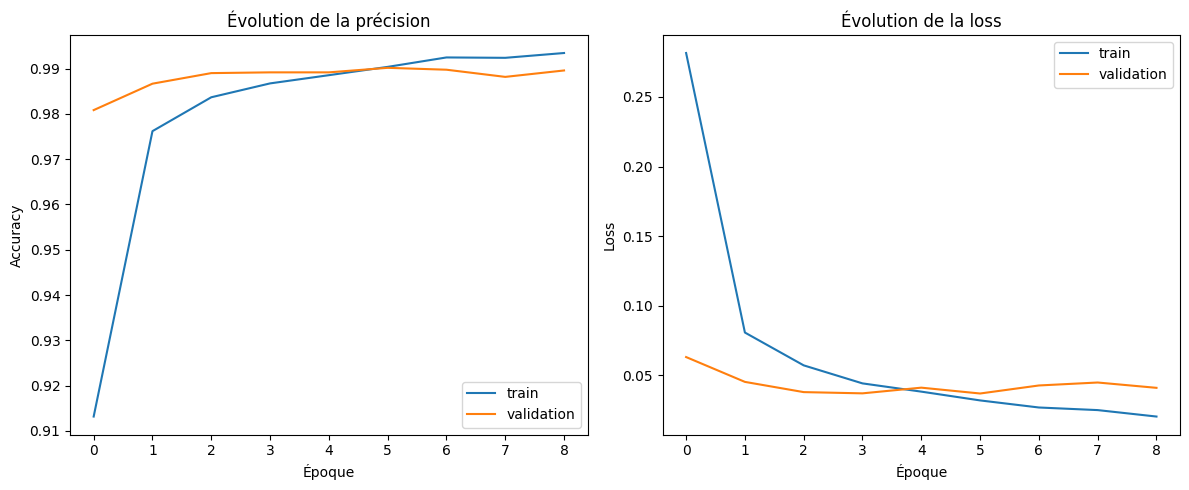

In [ ]:
#Visualiser les courbes accuracy et loss au cours des époques
plt.figure(figsize=(12,5))  # Largeur 12, hauteur 5

# Graphique 1 : Accuracy
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, premier graphique
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Évolution de la précision')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()

# Graphique 2 : Loss
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, deuxième graphique
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Évolution de la loss')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ajuste l'espacement automatiquement
plt.show()

L’analyse des courbes d’évolution de la précision et de la fonction de perte montre que le modèle a appris de manière efficace et stable au cours des époques. En effet, la précision sur les données d’entraînement augmente rapidement dès les premières itérations, passant d’environ 0,91 à plus de 0,98, avant de se stabiliser autour de 0,99. La précision sur les données de validation suit une tendance similaire et atteint également des valeurs élevées, proches de celles obtenues sur l’ensemble d’entraînement. Cette convergence des deux courbes indique que le modèle généralise bien et ne présente pas de signe notable de surapprentissage. De plus, l’évolution de la fonction de perte confirme cette observation : la loss d’entraînement diminue fortement au fil des époques, passant de 0,27 à moins de 0,02, tandis que celle de validation reste faible et relativement stable, autour de 0,04. L’absence d’écart significatif entre les pertes et précisions des deux ensembles témoigne d’un apprentissage équilibré. Globalement, ces résultats traduisent une bonne performance du modèle, capable de réaliser des prédictions précises tout en conservant une excellente capacité de généralisation.

Étape 5 : Évaluation du modèle
• Évaluer la performance sur les données de test :

In [ ]:
# Évaluation du modèle

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Accuracy sur le jeu de test :", test_acc)



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9891 - loss: 0.0355
Accuracy sur le jeu de test : 0.9919999837875366


L’évaluation du modèle sur le jeu de test a permis d’obtenir une accuracy de 99,2 % et une loss de 0,0355. Ces résultats confirment la très bonne capacité de généralisation du modèle, puisqu’ils sont cohérents avec les performances observées sur le jeu de validation (environ 99 %). Le faible taux de perte indique que les prédictions du réseau sont précises et stables. Ces performances témoignent de la pertinence de l’architecture choisie et de l’efficacité du processus d’apprentissage, tout en montrant que le modèle ne présente pas de surapprentissage significatif.

Afficher la matrice de confusion :

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


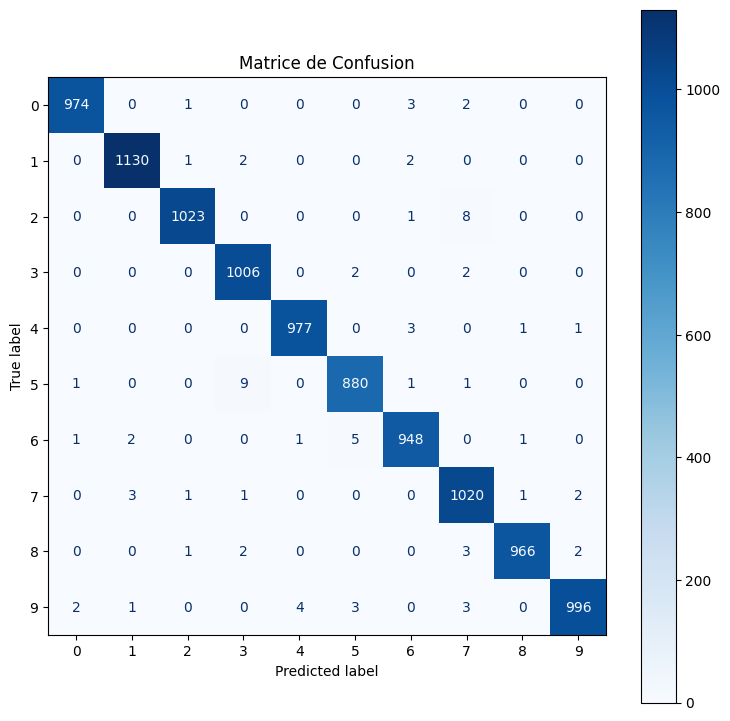

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)  # Exemples : plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges
plt.title("Matrice de Confusion")
plt.show()

La matrice de confusion présentée ci-dessus permet d’évaluer plus finement les performances du modèle sur l’ensemble de test. On observe que la grande majorité des prédictions se situent sur la diagonale principale, ce qui traduit une excellente correspondance entre les classes prédites et les classes réelles. En effet, pour chaque chiffre, le nombre d’exemples correctement classés est très élevé, souvent supérieur à 970 pour 1000 échantillons environ. Les erreurs de classification sont rares et se situent principalement entre certaines classes visuellement proches, comme les chiffres « 4 » et « 9 » ou « 5 » et « 6 ». Cette faible proportion d’erreurs témoigne d’une très bonne capacité de discrimination du modèle entre les différentes classes. Globalement, la matrice de confusion confirme les résultats précédents obtenus avec les courbes d’accuracy et de loss : le modèle présente une très forte précision globale et une excellente généralisation sur les données de test.

Étape 6 : Test de prédiction sur quelques images

Cette étape a pour objectif de vérifier visuellement les performances du modèle en affichant un échantillon aléatoire d’images du jeu de test accompagnées de leurs étiquettes réelles et des prédictions correspondantes. En procédant ainsi, on peut observer comment le modèle se comporte sur des données qu’il n’a jamais vues pendant l’entraînement et s’assurer qu’il reconnaît correctement les chiffres manuscrits. Cette visualisation permet également d’identifier d’éventuelles erreurs de classification et de comprendre dans quels cas le modèle peut confondre certaines classes. Dans le cas présent, toutes les prédictions réalisées sur les images sélectionnées se sont révélées exactes, ce qui confirme la fiabilité et la robustesse du modèle. Il s’agit donc d’un contrôle qualitatif complémentaire aux indicateurs quantitatifs (accuracy, loss, matrice de confusion), offrant une validation visuelle claire des excellentes performances du modèle.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


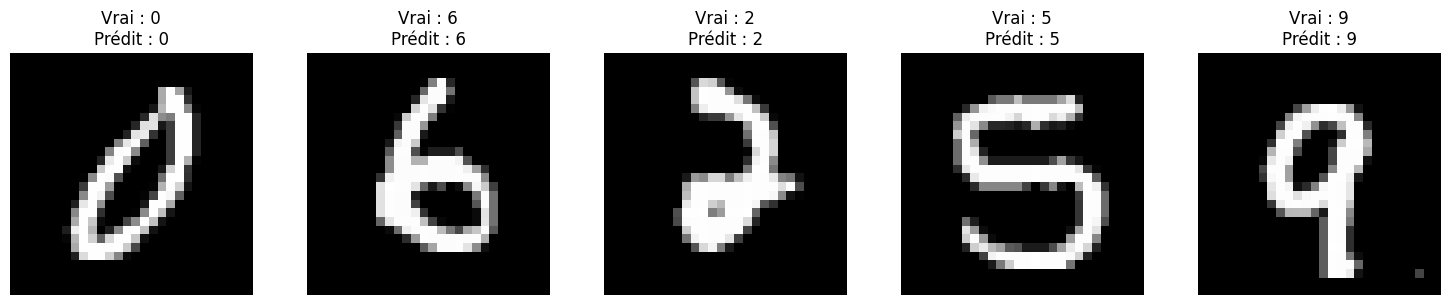

In [ ]:
idx = np.random.randint(0, len(x_test), 5)

plt.figure(figsize=(15, 3))  # Ajuste la taille pour que ce soit horizontal
for j, i in enumerate(idx):
    img = x_test[i]
    pred = np.argmax(model.predict(img.reshape(1,28,28,1)))

    plt.subplot(1, 5, j+1)  # 1 ligne, 5 colonnes, j+1ème image
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title(f"Vrai : {np.argmax(y_test[i])}\nPrédit : {pred}")
    plt.axis('off')  # Supprime les axes pour plus de clarté

plt.tight_layout()
plt.show()